# Соревнование по сентимент-анализу

В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в соревновании по сентимент-анализу отзывов на товары на Kaggle Inclass:

https://www.kaggle.com/c/simplesentiment

В качестве ответа в этом задании вам нужно загрузить ноутбук с решением и скриншот вашего результата на leaderboard.

Убедитесь, что:

1) ход вашего решения задокументирован достаточно подробно для того, чтобы ваши сокурсники поняли, что вы делали и почему;

2) ваша команда в соревновании состоит только из вас и названа вашим логином на Stepik, чтобы ваши сокурсники могли понять, что на скриншоте именно ваш результат.

 

In [7]:
import pandas as pd
#прочитаем данные по тренировочной выборке
data_train = pd.read_csv('products_sentiment_train.tsv', sep = '\t',header=None)
data_train.head()


,0,1
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [8]:
print(len(data_train))

2000


In [9]:
#прочитаем данные по тестовой выборке
data_test = pd.read_csv('products_sentiment_test.tsv', sep = '\t')
data_test.head()


,Id,text
0,0,"so , why the small digital elph , rather than ..."
1,1,3/4 way through the first disk we played on it...
2,2,better for the zen micro is outlook compatibil...
3,3,6 . play gameboy color games on it with goboy .
4,4,"likewise , i 've heard norton 2004 professiona..."


In [10]:
print(len(data_test))

500


Импортируем нужные нам модули

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


In [12]:
#тексты и метки
texts   = data_train[0]
labels  = data_train[1]

пробуем несколько разных классификаторов с настройками по умолчанию с CountVectorizer

In [39]:
def text_classifier(vectorizer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("classifier", classifier)]
        )

In [40]:
import warnings
warnings.filterwarnings('ignore')

for clf in [LogisticRegression, LinearSVC, SGDClassifier,MultinomialNB,RandomForestClassifier]:
    print(clf)
    print(cross_val_score(text_classifier(CountVectorizer(), clf()), texts, labels).mean())
    print ("\n")

<class 'sklearn.linear_model.logistic.LogisticRegression'>
0.7740071405738572


<class 'sklearn.svm.classes.LinearSVC'>
0.7505076290683487


<class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'>
0.7459963711837775


<class 'sklearn.naive_bayes.MultinomialNB'>
0.7795006400703551


<class 'sklearn.ensemble.forest.RandomForestClassifier'>
0.7115083599341471




Баесовский классификатор дает лучший результат. Пробуем работать с ним. По рекомендации курса делаем вычисления с этим классификатором без pipeline

In [15]:
clf_b = MultinomialNB()

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

0.7804655741393536


Пробуем применить Tfid вместо CountVectorizer

In [16]:
clf_b = MultinomialNB()

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

0.7100316382909572


Результат ухудшился. Вернемся к CountVectorizer. Пробуем с n-граммами и стоп словами 


In [18]:
clf_b = MultinomialNB()

vectorizer = CountVectorizer(ngram_range=(1,2))

X = vectorizer.fit_transform(texts)

print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

0.7904157478936973


In [19]:
clf_b = MultinomialNB()

vectorizer = CountVectorizer(ngram_range=(1,2),stop_words='english')
X = vectorizer.fit_transform(texts)

print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

0.7479475111877798


In [34]:
#вернемся к лучше модели, прогоним ее не всех данных и запишем ее в ответ

clf_b = MultinomialNB()
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
X_test = vectorizer.transform(data_test['text'])
predict_vector = clf_b.predict(X_test)
data_predict = pd.DataFrame({'Id': list(range(0, len(predict_vector))),'y': predict_vector})
data_predict.to_csv (r'submit.csv', index = None, header=True)

На тестовых данных Kaggle результат хуже, чем на нашей тестовой выборке. Вернемся к другим классификаторам - проверим LogisticRegression и LinearSVC с разными настройками векторайзерами 

In [41]:
#логистическая регрессия
warnings.filterwarnings('ignore')
clf_b = LogisticRegression(C=70, dual=True)
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


clf_b = LogisticRegression(C=70, dual=True)
vectorizer =  TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

clf_b = LogisticRegression(C=70, dual=True)
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words='english')
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


clf_b = LogisticRegression(C=70, dual=True)
vectorizer =  TfidfVectorizer(ngram_range=(1,2),stop_words='english')
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


0.7730079876996926
0.7889583114577865
0.7464826120653016
0.7529651991299783


In [42]:
#LinearSVC()
warnings.filterwarnings('ignore')
clf_b = LinearSVC()
vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


clf_b = LinearSVC()
vectorizer =  TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 

clf_b = LinearSVC()
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words='english')
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


clf_b = LinearSVC()
vectorizer =  TfidfVectorizer(ngram_range=(1,2),stop_words='english')
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
print(cross_val_score(clf_b,X, labels, cv=10).mean()) 


0.7690103752593815
0.7884632365809144
0.7429450986274656
0.7504626615665393


Лучший результат дает модель с использованием TfidfVectorizer(ngram_range=(1,2)). Оба классификатора дают примерно одни и те же оценки качества. 

In [46]:
clf_b = LogisticRegression(C=70, dual=True)

#clf_b = MultinomialNB()
vectorizer =  TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(texts)
clf_b.fit(X,labels)
X_test = vectorizer.transform(data_test['text'])
predict_vector = clf_b.predict(X_test)
data_predict = pd.DataFrame({'Id': list(range(0, len(predict_vector))),'y': predict_vector})
data_predict.to_csv (r'submit_lr.csv', index = None, header=True)
export_csv = data_predict.to_csv (r'submit_lr.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path


На каггле ответ примется - 0.81111

Посмотрим на топ10 признаков положительных и отрицательных классов и проанализируем их. 

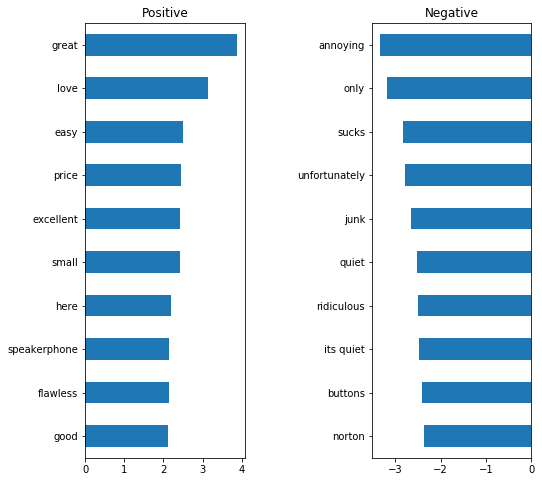

In [47]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

In [ ]:
Попробуем выбросить явно нейтральные слова из топа признаков, обучим модель заново и отправим результат на kaggle.

In [30]:
my_stop_words = ['buttons','they','only','after','and','your','norton','would']

In [49]:
model = LogisticRegression(C=70, dual=True)
vectorizer =  TfidfVectorizer(ngram_range=(1,2),stop_words = my_stop_words)
X = vectorizer.fit_transform(texts)
model.fit(X,labels)
print(cross_val_score(model,X, labels, cv=10).mean()) 


0.7699654491362284


In [50]:
model.fit(X,labels)
X_test = vectorizer.transform(data_test['text'])
predict_vector = model.predict(X_test)
data_predict = pd.DataFrame({'Id': list(range(0, len(predict_vector))),'y': predict_vector})
data_predict.head()
export_csv = data_predict.to_csv (r'submit_stop_words.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path


Результат на нашей трейн выборке ухудшился, но на kaggle он стал лучше - 0.81777 